<a href="https://colab.research.google.com/github/SeraphDev6/Pnuemonia_Image_Classification/blob/main/Pneumonia_X_Ray_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Classification by Wesley Giles

## Data Citation
Data: https://data.mendeley.com/datasets/rscbjbr9sj/2

License: CC BY 4.0

Citation: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

## Load data and necessary modules

In [29]:
! chmod 600 /root/.kaggle/kaggle.json
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
! unzip chest-xray-pneumonia.zip

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  chest-xray-pneumonia.zip
replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [30]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import os

In [31]:
image_gen = keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255)

train_gen = image_gen.flow_from_directory("/content/chest_xray/train/",
                                          class_mode = "sparse",
                                          classes=["NORMAL","PNEUMONIA"])
test_gen = image_gen.flow_from_directory("/content/chest_xray/test/",
                                          class_mode = "sparse",
                                          classes=["NORMAL","PNEUMONIA"])
val_gen = image_gen.flow_from_directory("/content/chest_xray/val/",
                                          class_mode = "sparse",
                                          classes=["NORMAL","PNEUMONIA"])

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Lets take a look at the balance of the train data

In [32]:
def get_file_counts(root):
  di = {}
  for dir in [d for d in os.listdir(root) if os.path.isdir(os.path.join(root,d))]:
    di[dir] = len([f for f in os.listdir(os.path.join(root,dir)) if os.path.isfile(os.path.join(root,dir,f))])
  return di
get_file_counts("/content/chest_xray/train/")

{'NORMAL': 1341, 'PNEUMONIA': 3875}

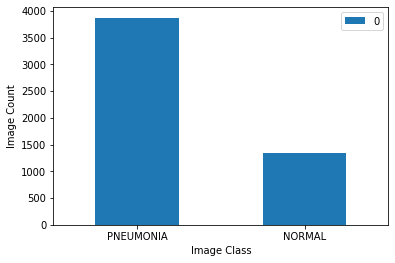

In [39]:
def get_bal_chart(root,title = None):
  bal = pd.DataFrame.from_dict(get_file_counts(root), orient = "index")
  bal.plot.bar()
  plt.gca().set_xlabel("Image Class")
  plt.gca().set_ylabel("Image Count")
  plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation = 0)
  if title:
    plt.gca().set_title(title)
  plt.show()
get_bal_chart("/content/chest_xray/train/")

## Seems we have significantly more Pnuemonia images than normal in this dataset, lets check test and val to ensure the same balance is in those sets

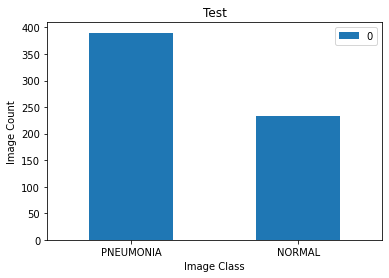

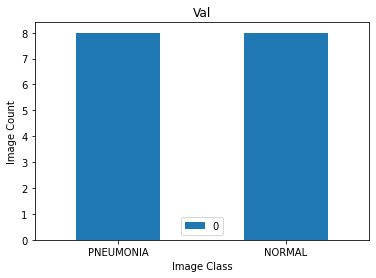

In [41]:
get_bal_chart("/content/chest_xray/test/", "Test")
get_bal_chart("/content/chest_xray/val/", "Val")

## While not perfectly balanced, both the train and test are skewed towards the positive indicator, which will allow us to more accurately predict Pnuemonia.